In [134]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from itertools import product
import shapely
import networkx as nx

%matplotlib inline

In [2]:
def find_recursive_csv_files(location='.'):
    foo = []
    for root, subdirs, files in os.walk(location):
        foo.extend([(root + '/' + x) for x in files if x[-4:] == '.csv'])
    return foo

## Loading LSOA geoshape data

In [3]:
data = gpd.read_file(
    './data/Lower_Layer_Super_Output_Areas_December_2011_Full_Extent__Boundaries_in_England_and_Wales.shp')

data.set_index('objectid')
data['place_name'] = data['lsoa11nm'].apply(lambda x: x[:-4].rstrip())

print(data.info())

data.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34753 entries, 0 to 34752
Data columns (total 8 columns):
objectid      34753 non-null int64
lsoa11cd      34753 non-null object
lsoa11nm      34753 non-null object
lsoa11nmw     34753 non-null object
st_areasha    34753 non-null float64
st_lengths    34753 non-null float64
geometry      34753 non-null object
place_name    34753 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 2.1+ MB
None


,objectid,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,geometry,place_name
0,1,E01000001,City of London 001A,City of London 001A,129865.337597,2635.781429,"POLYGON ((532153.3511221728 181867.6373986569,...",City of London
1,2,E01000002,City of London 001B,City of London 001B,228419.333117,2708.052040,"POLYGON ((532636.3044484088 181926.2382983296,...",City of London
2,3,E01000003,City of London 001C,City of London 001C,59054.013119,1224.770897,"POLYGON ((532155.5076535332 182165.4032334399,...",City of London
3,4,E01000005,City of London 001E,City of London 001E,189577.165141,2275.832056,"POLYGON ((533620.8853745657 181402.5745685115,...",City of London
4,5,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,146536.520438,1966.162225,"POLYGON ((545128.7281072272 184311.0094698063,...",Barking and Dagenham


## Loading Crime Data

In [4]:
df = pd.concat([pd.read_csv(x, index_col='Crime ID', parse_dates=[1]) for x in find_recursive_csv_files()])

print(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7096835 entries, 69419d07ef0810c62964c6ac9af7d7004ba5013df2a0165cb0ecff282fa2009a to 75a364bc060252eb354a9c910f8238061d39f3438a9b7ca1aa89f54b7355287a
Data columns (total 11 columns):
Month                    datetime64[ns]
Reported by              object
Falls within             object
Longitude                float64
Latitude                 float64
Location                 object
LSOA code                object
LSOA name                object
Crime type               object
Last outcome category    object
Context                  float64
dtypes: datetime64[ns](1), float64(3), object(7)
memory usage: 649.7+ MB
None


,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
Crime ID,,,,,,,,,,,
69419d07ef0810c62964c6ac9af7d7004ba5013df2a0165cb0ecff282fa2009a,2017-12-01,West Yorkshire Police,West Yorkshire Police,-1.409547,53.598298,On or near Ash Mount,E01007329,Barnsley 003A,Violence and sexual offences,Under investigation,NaN
0c857058e3567075ea2561d244b08b557c798a4a777e16c3e5691b2b2e5327d3,2017-12-01,West Yorkshire Police,West Yorkshire Police,-1.409547,53.598298,On or near Ash Mount,E01007329,Barnsley 003A,Other crime,Under investigation,NaN
ec0c5d0aa205ee3ff6591df5f3d834eb83da860d3c1ab83c9f1e5e4b5b1576dd,2017-12-01,West Yorkshire Police,West Yorkshire Police,-1.409547,53.598298,On or near Ash Mount,E01007329,Barnsley 003A,Other crime,Under investigation,NaN
NaN,2017-12-01,West Yorkshire Police,West Yorkshire Police,-1.550626,53.597400,On or near Swithen Hill,E01007359,Barnsley 005C,Anti-social behaviour,NaN,NaN
ce4b10db4be860b8d8899c594e8861fa3417c672910fa1b0489d3b8714be45db,2017-12-01,West Yorkshire Police,West Yorkshire Police,-1.863065,53.939035,On or near Low Mill,E01010646,Bradford 001A,Bicycle theft,Investigation complete; no suspect identified,NaN


In [5]:
df.reset_index().groupby(['LSOA code', 'Crime type']) \
    .agg({'Crime ID': 'size' }) \
    .reset_index()

,LSOA code,Crime type,Crime ID
0,E01000001,Anti-social behaviour,50
1,E01000001,Bicycle theft,21
2,E01000001,Burglary,9
3,E01000001,Criminal damage and arson,16
4,E01000001,Drugs,2
5,E01000001,Other crime,2
6,E01000001,Other theft,64
7,E01000001,Possession of weapons,1
8,E01000001,Public order,13
9,E01000001,Robbery,7


In [6]:
combined = pd.merge(
    data, 
    df.reset_index().groupby(['LSOA code', 'Crime type']) \
        .agg({'Crime ID': 'size' }) \
        .reset_index(),
    left_on='lsoa11cd',
    right_on='LSOA code')

print(combined.info())

combined.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 381970 entries, 0 to 381969
Data columns (total 11 columns):
objectid      381970 non-null int64
lsoa11cd      381970 non-null object
lsoa11nm      381970 non-null object
lsoa11nmw     381970 non-null object
st_areasha    381970 non-null float64
st_lengths    381970 non-null float64
geometry      381970 non-null object
place_name    381970 non-null object
LSOA code     381970 non-null object
Crime type    381970 non-null object
Crime ID      381970 non-null int64
dtypes: float64(2), int64(2), object(7)
memory usage: 35.0+ MB
None


,objectid,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,geometry,place_name,LSOA code,Crime type,Crime ID
0,1,E01000001,City of London 001A,City of London 001A,129865.337597,2635.781429,"POLYGON ((532153.3511221728 181867.6373986569,...",City of London,E01000001,Anti-social behaviour,50
1,1,E01000001,City of London 001A,City of London 001A,129865.337597,2635.781429,"POLYGON ((532153.3511221728 181867.6373986569,...",City of London,E01000001,Bicycle theft,21
2,1,E01000001,City of London 001A,City of London 001A,129865.337597,2635.781429,"POLYGON ((532153.3511221728 181867.6373986569,...",City of London,E01000001,Burglary,9
3,1,E01000001,City of London 001A,City of London 001A,129865.337597,2635.781429,"POLYGON ((532153.3511221728 181867.6373986569,...",City of London,E01000001,Criminal damage and arson,16
4,1,E01000001,City of London 001A,City of London 001A,129865.337597,2635.781429,"POLYGON ((532153.3511221728 181867.6373986569,...",City of London,E01000001,Drugs,2


In [7]:
a = combined[(combined['place_name'].str.contains('London'))]

In [8]:
a[a['Crime type'] == 'Drugs']

,objectid,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,geometry,place_name,LSOA code,Crime type,Crime ID
4,1,E01000001,City of London 001A,City of London 001A,1.298653e+05,2635.781429,"POLYGON ((532153.3511221728 181867.6373986569,...",City of London,E01000001,Drugs,2
18,2,E01000002,City of London 001B,City of London 001B,2.284193e+05,2708.052040,"POLYGON ((532636.3044484088 181926.2382983296,...",City of London,E01000002,Drugs,6
31,3,E01000003,City of London 001C,City of London 001C,5.905401e+04,1224.770897,"POLYGON ((532155.5076535332 182165.4032334399,...",City of London,E01000003,Drugs,2
43,4,E01000005,City of London 001E,City of London 001E,1.895772e+05,2275.832056,"POLYGON ((533620.8853745657 181402.5745685115,...",City of London,E01000005,Drugs,23
352197,32051,E01032739,City of London 001F,City of London 001F,1.855164e+06,8242.554363,"POLYGON ((533377.9803229205 181864.1103551402,...",City of London,E01032739,Drugs,199
352211,32052,E01032740,City of London 001G,City of London 001G,6.893861e+05,4630.122676,"POLYGON ((532021.9590720651 181805.9177792261,...",City of London,E01032740,Drugs,31


In [106]:
data.head()

,objectid,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,geometry,place_name
0,1,E01000001,City of London 001A,City of London 001A,129865.337597,2635.781429,"POLYGON ((532153.3511221728 181867.6373986569,...",City of London
1,2,E01000002,City of London 001B,City of London 001B,228419.333117,2708.052040,"POLYGON ((532636.3044484088 181926.2382983296,...",City of London
2,3,E01000003,City of London 001C,City of London 001C,59054.013119,1224.770897,"POLYGON ((532155.5076535332 182165.4032334399,...",City of London
3,4,E01000005,City of London 001E,City of London 001E,189577.165141,2275.832056,"POLYGON ((533620.8853745657 181402.5745685115,...",City of London
4,5,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,146536.520438,1966.162225,"POLYGON ((545128.7281072272 184311.0094698063,...",Barking and Dagenham


In [111]:
geo = data[['lsoa11cd', 'geometry']].copy()

geo.set_index('lsoa11cd')
print(geo.info())

geo.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34753 entries, 0 to 34752
Data columns (total 2 columns):
lsoa11cd    34753 non-null object
geometry    34753 non-null object
dtypes: object(2)
memory usage: 543.1+ KB
None


,lsoa11cd,geometry
0,E01000001,"POLYGON ((532153.3511221728 181867.6373986569,..."
1,E01000002,"POLYGON ((532636.3044484088 181926.2382983296,..."
2,E01000003,"POLYGON ((532155.5076535332 182165.4032334399,..."
3,E01000005,"POLYGON ((533620.8853745657 181402.5745685115,..."
4,E01000006,"POLYGON ((545128.7281072272 184311.0094698063,..."


In [158]:
G = nx.from_pandas_edgelist(
    pd.merge(
        pd.DataFrame([(x[1][0], y[1][0]) for x, y in 
                         product(geo.iloc[0:10].iterrows(), geo.iloc[0:10].iterrows()) 
                         if x[1][1].touches(y[1][1])], columns=['source', 'target']),
             df.reset_index().groupby(['LSOA code']).agg({'Reported by': 'first',
                                'Crime ID': 'size'}).reset_index(),
             left_on='source', right_on='LSOA code'))

## Plotting City of London

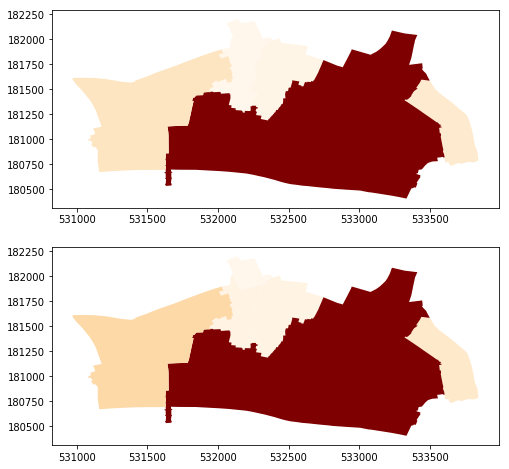

In [86]:

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(211)
a[a['Crime type'] == 'Drugs'].plot(column='Crime ID', cmap='OrRd', ax=ax1)
ax2 = fig.add_subplot(212)
a[a['Crime type'] == 'Violence and sexual offences'].plot(column='Crime ID', cmap='OrRd', ax=ax2)

